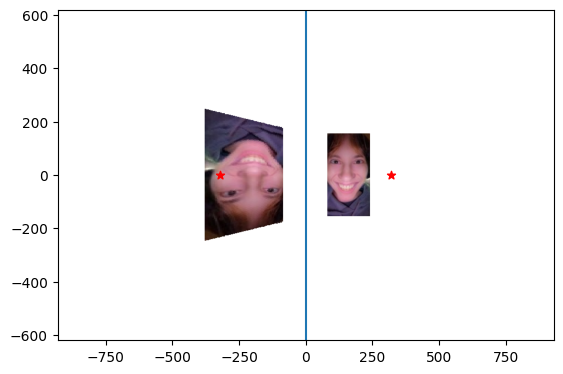

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint

#Everything before "image = plt.imread(image)" is just on ellas request, before we actually submit it would be replaced
choice = input("Tall (T) or Wide (W)")
while choice.upper() != "T" and choice.upper() != "W":
    choice = input("Tall (T) or Wide (W)")
if choice.upper() == "T":
    ella_hugo_BOSS_ulbrich = randint(1,22)
    if ella_hugo_BOSS_ulbrich == 7:
        image = "Tall2.jpg"
        #Thales: 80 wide, 134 high
    else:
        image = "Tall1.jpg"
        #Ella: 80 wide, 155 high
else:
    image = "aWide.jpg"
    #164 wide, 80 high

image = plt.imread(image)
size = max(image.shape[0],image.shape[1])*4
canvas = np.zeros((size, int(size*1.5), image.shape[2]), dtype=np.uint8)
canvas += 255
f = int(4*image.shape[1])
start_x = int(0.5*image.shape[1])
start_y = int(-0.5*image.shape[0])
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        colour = image[y, x]
        old_x = x + start_x
        old_y = y + start_y
        new_x = int(-(f*old_x) / (old_x-f))
        new_y = int((old_y/old_x)*new_x)
        try:
            canvas[(size//2)+old_y, (3*size//4)+old_x] = colour
        except:
            continue
        for dy in range(-1, 2):
            for dx in range(-1, 2):
                try:
                    canvas[(size//2)+new_y+dy, (3*size//4)+new_x+dx] = colour
                except:
                    continue

plt.imshow(canvas, extent=[-size*1.5, size*1.5, -size, size])
plt.xlim(-size*1.5, size*1.5)
plt.ylim(-size, size)
plt.axvline(x=0)
plt.scatter(f, 0, color='red', marker='*')
plt.scatter(-f, 0, color='red', marker='*')

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from time import perf_counter
import ipywidgets as widgets
from ipywidgets import interact

# --- Task 7 Image Selection ---
choice = input("Tall (T) or Wide (W): ")
while choice.upper() not in ("T", "W"):
    choice = input("Tall (T) or Wide (W): ")

if choice.upper() == "T":
    if randint(1, 22) == 7:
        image_file = "Tall2.jpg"  # Thales: 80 wide, 134 high
    else:
        image_file = "Tall1.jpg"  # Ella: 80 wide, 155 high
else:
    image_file = "aWide.jpg"      # 164 wide, 80 high

image = plt.imread(image_file)
img_height, img_width, channels = image.shape

def update_task7(start_x, start_y):
    t0 = perf_counter()
    f_val = int(4 * img_width)
    
    # Set up the canvas dimensions.
    size = max(img_height, img_width) * 4
    canvas_height = size
    canvas_width = int(size * 1.5)
    canvas = np.full((canvas_height, canvas_width, channels), 255, dtype=np.uint8)
    
    # These fixed offsets position the canvas within the image.
    offset_y = canvas_height // 2
    offset_x = 3 * canvas_height // 4
    
    # Create coordinate arrays for the image.
    yy, xx = np.indices((img_height, img_width))
    old_x = xx + start_x
    old_y = yy + start_y
    
    new_x_float = - (f_val * old_x) / (old_x - f_val)
    new_x = new_x_float.astype(int)
    new_y_float = (old_y / old_x) * new_x_float
    new_y = new_y_float.astype(int)
    
    old_canvas_y = offset_y + old_y
    old_canvas_x = offset_x + old_x
    new_canvas_y = offset_y + new_y
    new_canvas_x = offset_x + new_x
    
    valid_old = (old_canvas_y >= 0) & (old_canvas_y < canvas_height) & \
                (old_canvas_x >= 0) & (old_canvas_x < canvas_width)
    canvas[old_canvas_y[valid_old], old_canvas_x[valid_old]] = image[yy[valid_old], xx[valid_old]]
    
    valid_new = (new_canvas_y >= 0) & (new_canvas_y < canvas_height) & \
                (new_canvas_x >= 0) & (new_canvas_x < canvas_width)
    canvas[new_canvas_y[valid_new], new_canvas_x[valid_new]] = image[yy[valid_new], xx[valid_new]]
    
    all_new_x = new_canvas_x[valid_new].ravel()
    all_new_y = new_canvas_y[valid_new].ravel()
    raw_min_x = int(all_new_x.min())
    raw_max_x = int(all_new_x.max())
    raw_min_y = int(all_new_y.min())
    raw_max_y = int(all_new_y.max())
    
    bb_left = max(raw_min_x, 0)
    bb_right = min(raw_max_x, canvas_width - 1)
    bb_top = max(raw_min_y, 0)
    bb_bottom = min(raw_max_y, canvas_height - 1)
    
    def fix_row(row, left, right):
        cols = np.arange(left, right+1)
        row_slice = canvas[row, left:right+1]
        mask = (row_slice != 255).any(axis=1)
        if mask.sum() < 2:
            return
        filled_cols = cols[mask]
        seg_left = filled_cols[0]
        seg_right = filled_cols[-1]
        interp_cols = np.arange(seg_left, seg_right+1)
        for ch in range(channels):
            xp = filled_cols
            fp = row_slice[mask, ch]
            interpolated = np.interp(interp_cols, xp, fp)
            canvas[row, interp_cols, ch] = np.around(interpolated).astype(np.uint8)
    
    def fix_col(col, top, bottom):
        rows = np.arange(top, bottom+1)
        col_slice = canvas[top:bottom+1, col]
        mask = (col_slice != 255).any(axis=1)
        if mask.sum() < 2:
            return
        filled_rows = rows[mask]
        seg_top = filled_rows[0]
        seg_bottom = filled_rows[-1]
        interp_rows = np.arange(seg_top, seg_bottom+1)
        for ch in range(channels):
            xp = filled_rows
            fp = col_slice[mask, ch]
            interpolated = np.interp(interp_rows, xp, fp)
            canvas[interp_rows, col, ch] = np.around(interpolated).astype(np.uint8)
    
    for col in range(bb_left, bb_right+1):
        fix_col(col, bb_top, bb_bottom)
    for row in range(bb_top, bb_bottom+1):
        fix_row(row, bb_left, bb_right)
    
    t_elapsed = perf_counter() - t0
    print("Task 7 processing time: {:.4f} seconds".format(t_elapsed))
    
    plt.figure(figsize=(8,6))
    extent_val = [-size*1.5, size*1.5, -size, size]
    plt.imshow(canvas, extent=extent_val)
    plt.xlim(extent_val[0], extent_val[1])
    plt.ylim(extent_val[2], extent_val[3])
    plt.axvline(x=0, color='black', linestyle='--')
    plt.scatter(f_val, 0, color='red', marker='*')
    plt.scatter(-f_val, 0, color='red', marker='*')
    plt.title(f"Task 7: start_x = {start_x}, start_y = {start_y}")
    plt.show()

interact(update_task7,
         start_x=widgets.IntSlider(min=-int(1.5*img_width), max=int(1.5*img_width), step=1, value=int(1.20*img_width), description="start_x"),
         start_y=widgets.IntSlider(min=-int(1.5*img_height), max=int(1.5*img_height), step=1, value=int(-0.5*img_height), description="start_y"));

Tall (T) or Wide (W):  T


interactive(children=(IntSlider(value=96, description='start_x', max=120, min=-120), IntSlider(value=-67, desc…